<a href="https://colab.research.google.com/github/cccadet/dermatologist-ai/blob/master/01_Train1_ISIC_2019_DeepStack_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré: Conexão com Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Etapa 1: Instalação das dependências

### Instalação de bibliotecas

In [3]:
!pip install tensorflow-gpu
!pip install tqdm
#!pip install tensorflow-addons
!pip install tfa-nightly
!pip install deepstack

     |████████████████████████████████| 320.4MB 47kB/s 
     |████████████████████████████████| 1.1MB 2.9MB/s 


### Importação das bibliotecas

In [4]:
import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import pandas as pd
import sys
import itertools
import shutil

from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
tf.__version__

'2.3.0'

### Otimizações tensorflow

In [5]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
tf.config.optimizer.set_jit(True)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Fazendo o download da base de dados de imagens

In [6]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip \
      -O ./skin_cancer_train_2018.zip


--2020-09-23 13:24:52--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.100.68
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.100.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2771732744 (2.6G) [application/zip]
Saving to: ‘./skin_cancer_train_2018.zip’

./skin_cancer_train 100%[===================>]   2.58G  50.2MB/s    in 43s     

2020-09-23 13:25:35 (61.0 MB/s) - ‘./skin_cancer_train_2018.zip’ saved [2771732744/2771732744]

CPU times: user 319 ms, sys: 118 ms, total: 437 ms
Wall time: 46.5 s


In [7]:
%%time
if (os.path.isdir('./ISIC_Training_Input')==False):
  !wget --no-check-certificate \
      https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip \
      -O ./skin_cancer_train_2019.zip

--2020-09-23 13:25:38--  https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.45.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.45.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9771618190 (9.1G) [application/zip]
Saving to: ‘./skin_cancer_train_2019.zip’

./skin_cancer_train 100%[===================>]   9.10G  41.6MB/s    in 4m 3s   

2020-09-23 13:29:41 (38.4 MB/s) - ‘./skin_cancer_train_2019.zip’ saved [9771618190/9771618190]

CPU times: user 1.52 s, sys: 521 ms, total: 2.04 s
Wall time: 4min 3s


## Etapa 2: Pré-processamento

### Configurando os caminhos (paths)

In [8]:
train_dir = "./train"
if not os.path.exists(train_dir): 
  os.mkdir(train_dir)
valid_dir = "./valid"
if not os.path.exists(valid_dir): 
  os.mkdir(valid_dir)


download_path = './'
derm_ai_path = '/content/drive/My Drive/Derm AI/ISIC_2019'


### Definindo função para descompactar arquivo

In [9]:
def dcp(download_path, path, file):
  if (os.path.isdir(path)==False):
    dataset_path = os.path.join(download_path,file)
    zip_object = zipfile.ZipFile(file=dataset_path, mode="r")
    zip_object.extractall("./")
    zip_object.close()

### Descompactando a base de dados de Treinamento

In [10]:
%%time
dcp(download_path, './ISIC2018_Task3_Training_Input', 'skin_cancer_train_2018.zip')

CPU times: user 7.95 s, sys: 5.23 s, total: 13.2 s
Wall time: 1min 32s


In [11]:
!rm ./skin_cancer_train_2018.zip

In [12]:
%%time
dcp(download_path, './ISIC_2019_Training_Input', 'skin_cancer_train_2019.zip')

CPU times: user 54.3 s, sys: 17.3 s, total: 1min 11s
Wall time: 4min 46s


In [13]:
!rm ./skin_cancer_train_2019.zip

### Definindo DataFrame base para criação das pastas de cada classe

In [14]:
!wget --no-check-certificate \
      https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip \
      -O ./ground_truth.zip


zip_object = zipfile.ZipFile(file='ground_truth.zip', mode="r")
zip_object.extractall("./")
zip_object.close()

--2020-09-23 13:36:01--  https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.227.152
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36681 (36K) [application/zip]
Saving to: ‘./ground_truth.zip’

./ground_truth.zip  100%[===================>]  35.82K  --.-KB/s    in 0.01s   

2020-09-23 13:36:01 (2.78 MB/s) - ‘./ground_truth.zip’ saved [36681/36681]



In [15]:
# Read in the data
ground_truth1 = pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')
ground_truth2 = pd.read_csv('/content/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
ground_truth2['AK'] = ground_truth2['AKIEC']
ground_truth2.drop(columns=['AKIEC'], inplace=True)
ground_truth = pd.concat([ground_truth1,ground_truth2])

# Display some information in the dataset
ground_truth.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
!mkdir ISIC_Training_Input
!mv /content/ISIC2018_Task3_Training_Input/*.jpg /content/ISIC_Training_Input
!mv /content/ISIC_2019_Training_Input/*.jpg /content/ISIC_Training_Input

### Separando base de treinamento e de validação

In [17]:
# Set y as the labels
y = []
for row in ground_truth.iterrows():
    innerlist = []
    newlist = row[1].index[row[1].values[1:].argmax() + 1]
    y.append(newlist)


#add a name to the label series
yd = pd.Series(y) 
yd.name = 'cclass'

from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(ground_truth, test_size=0.2, random_state=41, stratify=yd)

# Get a list of images in each of the two folders
folder = os.listdir('ISIC_Training_Input')

# Get a list of train and val images
#all_list = list(ground_truth['image'])
#
train_list = list(df_train['image'])
val_list = list(df_val['image'])

### Criando subdiretório das classes

In [18]:
#create sub directory for the classes
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        dir_path = os.path.join(train_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)
        dir_path = os.path.join(valid_dir, col)
        if not os.path.exists(dir_path):
          os.mkdir(dir_path)

### Transferindo arquivos - base de treinamento

In [19]:
%%time
# Transfer the training images
for row in df_train.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 18.9 s, sys: 17.3 s, total: 36.2 s
Wall time: 3min 53s


### Transferindo arquivos - base de validação

In [20]:
%%time
# Transfer the valid images
for row in df_val.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join('ISIC_Training_Input', fname)
        # destination path to image
        dst = os.path.join(valid_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

CPU times: user 4.75 s, sys: 4.52 s, total: 9.27 s
Wall time: 1min 3s


### Números das bases de treinamento

In [21]:
# training examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 3790
NV 11392
BCC 2749
AK 874
BKL 2277
DF 211
VASC 233
SCC 502
total =  22028


### Números das bases de validação

In [22]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)

MEL 1086
NV 3637
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  6669


### Balanceamento base de validação

In [23]:
import os, random
mellen = len(os.listdir('./valid/MEL'))
nvlen = len(os.listdir('./valid/NV'))
for i in range(nvlen - mellen):
    file = random.choice(os.listdir("./valid/NV"))
    dst = os.path.join(valid_dir,'NV', file)
    os.remove(dst)

In [24]:
# validation examples
total = 0
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        npath = os.path.join(valid_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

MEL 1086
NV 1086
BCC 746
AK 231
BKL 701
DF 67
VASC 75
SCC 126
total =  4118


AK
BCC
BKL
DF
MEL Melanoma
NV
SCC
VASC

### Criando pesos das classes

### Criando geradores de dados (Data Generators)


In [25]:
# Data Augmentation (https://keras.io/preprocessing/image/)
data_gen_train = ImageDataGenerator(#validation_split=0.2,
                                    rescale=1/255., 
                                    horizontal_flip= True, 
                                    vertical_flip = True, 
                                    height_shift_range=0.10, 
                                    width_shift_range=0.10,
                                    rotation_range=180,
                                    shear_range=0.01,
                                    zoom_range=[0.95, 1.25],
                                    fill_mode='constant',
                                    #data_format='channels_last',
                                    brightness_range=[0.9, 1.1]
                                    )

data_gen_valid = ImageDataGenerator(rescale=1/255., 
                                   fill_mode="constant"
)



In [26]:
train_generator = data_gen_train.flow_from_directory(train_dir, target_size=(299,299), batch_size=32, class_mode="categorical")
valid_generator = data_gen_valid.flow_from_directory(valid_dir, target_size=(299,299), batch_size=32, class_mode="categorical")

Found 22028 images belonging to 8 classes.
Found 4118 images belonging to 8 classes.


#### Exibição de 3 imagens carregadas

[0. 0. 1. 0. 0. 0. 0. 0.]


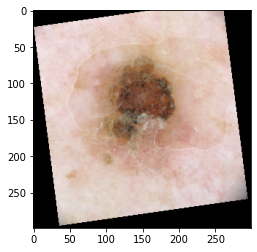

[0. 0. 1. 0. 0. 0. 0. 0.]


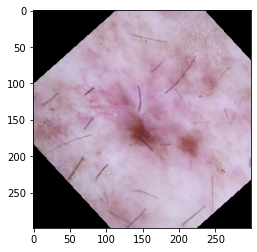

[0. 0. 0. 0. 0. 1. 0. 0.]


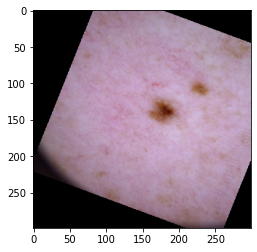

In [27]:
x,y = train_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [28]:
import numpy as np

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(train_generator.classes), class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes))) 


class_weights
train_generator.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

## Etapa 3: Construindo o modelo

In [150]:
%%time
#print("Model1")
#model1 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model1_B7'))
print("Model2")
model2 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model2_InceptionResnetV2'))
#print("Model3")
#model3 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model3_NasNet_Large'))
#print("Model4")
#model4 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model4_InceptionV3'))
print("Model5")
model5 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'model5_Xception'))
print("Model6")
model6 = tf.keras.models.load_model(os.path.join(derm_ai_path, 'B1-IRN50V2_3'))

Model2
Model5
Model6
CPU times: user 5min 28s, sys: 12.5 s, total: 5min 40s
Wall time: 6min 18s


In [30]:
%%time
from deepstack.base import KerasMember

#member1 = KerasMember(name="model1", keras_model=model1, train_batches=train_generator, val_batches=valid_generator)
member2 = KerasMember(name="model2", keras_model=model2, train_batches=train_generator, val_batches=valid_generator)
#member3 = KerasMember(name="model3", keras_model=model3, train_batches=train_generator, val_batches=valid_generator)
#member4 = KerasMember(name="model4", keras_model=model4, train_batches=train_generator, val_batches=valid_generator)
member5 = KerasMember(name="model5", keras_model=model5, train_batches=train_generator, val_batches=valid_generator)
member6 = KerasMember(name="model6", keras_model=model6, train_batches=train_generator, val_batches=valid_generator)


129/129 [==============================] - 67s 516ms/step
CPU times: user 47min 21s, sys: 2min 52s, total: 50min 14s
Wall time: 45min 46s


### DirichletEnsemble

In [31]:
%%time
import sklearn
from deepstack.ensemble import DirichletEnsemble

wAvgEnsemble = DirichletEnsemble(metric=sklearn.metrics.accuracy_score)
#wAvgEnsemble.add_members([member1, member2, member3, member4, member5, member6])
wAvgEnsemble.add_members([member2, member5, member6])
wAvgEnsemble.fit()
wAvgEnsemble.describe()

model2 - Weight: 0.2668 - accuracy_score: 0.9517
model5 - Weight: 0.0377 - accuracy_score: 0.9308
model6 - Weight: 0.6955 - accuracy_score: 0.9678
DirichletEnsemble accuracy_score: 0.9737
CPU times: user 2min 23s, sys: 149 ms, total: 2min 23s
Wall time: 2min 23s


### StackEnsemble

In [32]:
#License: MIT
from deepstack.ensemble import StackEnsemble
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#Ensure you have the scikit-learn version >= 0.22 installed
print("sklearn version must be >= 0.22. You have:", sklearn.__version__)

stack = StackEnsemble()

# 2nd Level Meta-Learner
estimators = [
    ('rf', RandomForestClassifier(verbose=0, n_estimators=200, max_depth=15, n_jobs=20, min_samples_split=30)),
    ('etr', ExtraTreesClassifier(verbose=0, n_estimators=200, max_depth=10, n_jobs=20, min_samples_split=20))
]
# 3rd Level Meta-Learner
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=1000)
)

stack.model = clf
stack.add_members([member2, member5, member6])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

sklearn version must be >= 0.22. You have: 0.22.2.post1
Calling predict
model2 - accuracy_score: 0.9517
model5 - accuracy_score: 0.9308
model6 - accuracy_score: 0.9678
StackEnsemble accuracy_score: 0.8082


0.8081593006313744

In [36]:
stack_folder = os.path.join(derm_ai_path, 'stack_')
stack.save(stack_folder)

<StackEnsemble: [model2, model5, model6]>

In [37]:
stack.load(stack_folder)

Loaded model2
Loaded model5
Loaded model6


<StackEnsemble: [model2, model5, model6]>

In [69]:
from numpy import dstack
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	#stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [75]:
%%time
predictions = stacked_dataset([model2, model5, model6],valid_generator)

CPU times: user 3min 42s, sys: 10.6 s, total: 3min 53s
Wall time: 3min 22s


In [76]:
predictions[0]

array([[8.6702093e-02, 1.2503843e-01, 1.2143055e-01],
       [4.5487118e-01, 6.3184321e-01, 4.7006160e-03],
       [8.2810171e-02, 7.1536437e-02, 9.7122394e-02],
       [2.8677585e-03, 2.2912777e-03, 3.3326444e-06],
       [5.0900392e-03, 8.4798880e-02, 6.2747966e-03],
       [1.7009422e-03, 1.7685317e-02, 1.2671635e-05],
       [3.6592701e-01, 6.6661917e-02, 7.7045566e-01],
       [3.0808664e-05, 1.4461778e-04, 4.2378345e-09]], dtype=float32)

In [77]:
%%time
# Create a confusion matrix of the test images
val_labels = valid_generator.classes
# Make predictions
#val_predictions = stack.predict(stacked_dataset([model2, model5, model6],valid_generator))
val_predictions = stack.predict(predictions)


Calling predict
CPU times: user 475 ms, sys: 100 ms, total: 575 ms
Wall time: 419 ms


Confusion matrix, without normalization
[[  20    3  167    0   41    0    0    0]
 [  69   31  559    0   62   18    6    1]
 [ 212   61  415    0    9    1    1    2]
 [  21    5   22    0   15    0    3    1]
 [ 177  276  495    0   87   46    5    0]
 [  29 1043   12    0    0    0    0    2]
 [   5    1   55    0   65    0    0    0]
 [   0    0    0    0    0   67    3    5]]


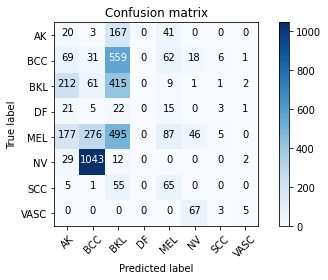

In [74]:
from sklearn.metrics import confusion_matrix

# Declare a function for plotting the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(val_labels, val_predictions) #.argmax(axis=1))

cm_plot_labels = ['AK' , 'BCC' , 'BKL' , 'DF' , 'MEL' , 'NV' , 'SCC'	, 'VASC']

plot_confusion_matrix(cm, cm_plot_labels)

In [158]:
#X, Y = valid_generator.next()    
#Y=np.zeros(X.shape[0])
valid_generator_ = data_gen_valid.flow_from_directory(valid_dir, target_size=(299,299), batch_size=1000, class_mode="categorical")
x_test, y_test = valid_generator_.next() 

Found 4118 images belonging to 8 classes.


In [ ]:
from sklearn.metrics import accuracy_score
import numpy as np
models=[model2, model5,model6]
model_names=["model2_InceptionResnetV2", "model5_Xception","B1-IRN50V2_3"]
for model,model_name in zip(models,model_names):
    y_prob = model.predict(x_test)
    y_pred1 = y_prob.argmax(axis=-1)
    y_test1=y_test #np.argmax(Y, axis=1)
    # accuracy
    print(model_name+" accuracy: ",accuracy_score(y_test1,y_pred1))
    del model , y_pred1, y_test1

In [155]:
#VotingClassifier(hard)
li = ['AK' , 'BCC' , 'BKL' , 'DF' , 'MEL' , 'NV' , 'SCC'	, 'VASC']
estimators = [model2, model5,model6]
vc=votingClassifer(estimators=estimators,mode="hard",show_info="percent")
index_classes, class_names, probs=vc.predict(x_test)

percent: 100.00%

In [157]:
# inverse_to_categorical inverser format binary to format indexation
# datagenerator use the methode to_categorical for labelsation to frmat binary 
# the method inverce of to_categorical is argmax
import numpy as np
y_test1=y_test #np.argmax(y_test, axis=1)
y_pred1=index_classes

# accuracy
from sklearn.metrics import accuracy_score
print("votingClassifer(hard) accuracy : ",accuracy_score(y_test1,y_pred1))

votingClassifer(hard) accuracy :  0.2857142857142857


In [153]:
# predicting an image
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

class votingClassifer:
    'votingClassifer class'


    def __init__(self, estimators,mode="hard",weight=None,show_info="percent"):
        
        if mode not in ["hard","soft"]:
            raise Exception("the mode should be 'hard' or 'soft'")
            
        self.estimators=estimators
        self.mode=mode
        self.weight=weight
        self.show_info=show_info  
            
    def predict(self,x_test):        
        if self.mode=="hard":
            return self.votingClassifer_hard(self.estimators, x_test, show_info=self.show_info)
        else:
            return self.votingClassifer_soft(self.estimators, x_test, weight=self.weight, show_info=self.show_info)

    def getNumberDiff(self, index_classes, n):  
        
        for x in index_classes:
            if index_class_prefer != x:
                return x    
    
    def getNumberElse(self, index_classes, n):

        indices = [i for i, value in enumerate(index_classes) if value != n]
        counts = np.bincount(indices)
        ind=np.argmax(counts)
        n1=(indices == ind).sum()
 
                
        return n1
    
    
    def votingClassifer_hard(self,estimators,x_test,show_info='percent'):
        
        if show_info not in ["info","percent","nothing"]:
            raise Exception("the attribut 'show_info' should be 'info' or 'percent','nothing'")            
            
        
        cpt=0
        index_classes_glob, class_names_glob, probs_glob=[],[],[]
        N=len(x_test)
        for x in x_test:
            index_classes, class_names, probs=[],[],[]
            for model in estimators:
                img = np.expand_dims(x, axis=0)
                # make a prediction
                y_prob = model.predict(img)[0]
                probabilty = y_prob.flatten()
                max_prob = probabilty.max()
                y_classes = y_prob.argmax(axis=-1)
                index_class, class_name, prob = y_classes,li[y_classes],max_prob
                index_classes.append(index_class)
                class_names.append(class_name)
                probs.append(prob)
            index_classes, class_names, probs = np.array(index_classes), np.array(class_names), np.array(probs)    
            counts = np.bincount(index_classes)
            index_class_prefer=np.argmax(counts)
 
            n1=(index_classes == index_class_prefer).sum()
    
            if n1 == 1:
                print("\n Each estimator predict a different class")
                prob = probs.max()
                indice = [i for i, value in enumerate(probs) if value == prob][0]
                class_name = class_names[indice]

                
            elif n1 == len(estimators)/2 and len(estimators)/2 == self.getNumberElse(index_classes, index_class_prefer):
                
                print("\n the half-estimators predict a class and the other estimators predict a different class")
                
                indices1 = [i for i, value in enumerate(index_classes) if value == index_class_prefer]
                sum2=0
                for ind in indices1:
                    sum2+=probs[ind]
                
                prob1=sum2/len(indices1)
                
                n2=self.getNumberDiff(index_classes, index_class_prefer)      
                
                indices2 = [i for i, value in enumerate(index_classes) if value == n2]
                sum2=0
                for ind in indices2:
                    sum2+=probs[ind]
                
                prob2=sum2/len(indices2)
                
                if prob1 < prob2:
                    prob=prob2
                    indice = [i for i, value in enumerate(index_classes) if value == n2][0]
                    class_name = class_names[indice]
                    
                else:
                    prob=prob1
                    indice = [i for i, value in enumerate(index_classes) if value == index_class_prefer][0]
                    class_name = class_names[indice]
                
            else:
                
                sum1=0
                nbr=0
                for i, index in zip(range(len(probs)),index_classes):
                    if index_class_prefer== index:
                        sum1+=probs[i]
                        nbr+=1
                        
                prob=sum1/nbr
                indice = index_class_prefer
                class_name = li[index_class_prefer]

            
            if show_info=="info":
                cpt+=1
                print("\rpercent: {:.2f}%, li[{}]:{} --> {}".format(cpt*100/N,index_class_prefer, li[index_class_prefer], prob), end='')   
            elif show_info=="percent":
                cpt+=1
                print("\rpercent: {:.2f}%".format(cpt*100/N), end='')
          
                
            index_classes_glob.append(indice)
            class_names_glob.append(class_name)
            probs_glob.append(prob)

        return np.array(index_classes_glob), np.array(class_names_glob), np.array(probs_glob) 
    
    
    def votingClassifer_soft(self, estimators, x_test, weight=None, show_info="percent"):
        
        if show_info not in ["info","percent","nothing"]:
            raise Exception("the attribut 'show_info' should be 'info' or 'percent','nothing'")  

        if weight is None :
            weight=np.ones(len(estimators))

        if len(weight) != len(estimators):
            raise Exception("number of models and wheight should be equals")    

        cpt=0 
        # get number of classes 
        x = image.img_to_array(x_test[0])
        x = np.expand_dims(x, axis=0)
        y_prob = estimators[0].predict(x) 
        num_classes =  y_prob.shape[1]

        Tab=np.zeros(num_classes)# num_classes
        index_classes_glob, class_names_glob, probs_glob=[],[],[]
        N=len(x_test)
        for x in x_test:
            index_classes, class_names, probs= [], [], []
            for model in estimators:
                img = np.expand_dims(x, axis=0)
                # make a prediction
                y_prob = model.predict(img)[0]
                idxs = np.argsort(y_prob)
                # loop over the indexes of the high confidence class labels
                for (index, value) in enumerate(idxs):
                    # build the label and draw the label on the image
                    #label = "{}) {}[{}]: {:.2f}%".format(index,li[value],value, y_prob[value] * 100)
                    #print(label)
                    Tab[value]=y_prob[value]

                probs.append(Tab)

            probs=np.array(probs) # probs.shape: (3, 38)

            proba=[]   

            div=sum(weight)
            for i in range(len(probs[0])):
                s=0
                for j in range(len(weight)):
                    s+= probs[j][i] * weight[j] 
                s=s/div
                proba.append(s)

            proba=np.array(proba)
            max_prob=max(proba)

            indices=[i for i, value in enumerate(proba) if value == max_prob]

            index_class, class_name, prob=indices[0],li[indices[0]],max_prob 

            index_classes_glob.append(index_class)
            class_names_glob.append(class_name)
            probs_glob.append(prob) 

            if show_info=="info":
                cpt+=1
                print("percent: {:.2f}%, li[{}]:{} --> {}%".format(cpt*100/N,index_class, li[index_class], prob))   
            elif show_info=="percent":
                cpt+=1
                print("\rpercent: {:.2f}%".format(cpt*100/N), end='')



        return np.array(index_classes_glob), np.array(class_names_glob), np.array(probs_glob)  